# Tabular Classification Benchmarks for SG-FIGS Evaluation

This notebook demonstrates the **tabular classification benchmark dataset** used for evaluating the SG-FIGS (Synergy-Guided Feature Interaction Graph Splits) method.

**What it does:**
- Loads a curated collection of standardized tabular classification benchmarks
- Each dataset has named features (enabling interpretability evaluation) and documented feature interactions (for PID synergy analysis)
- Datasets span medical, signal processing, food science, computer vision, image processing, and botany domains
- Each example contains JSON-serialized feature values, integer class labels, 5-fold CV assignments, and metadata

**Data structure:** Each entry has `input` (JSON string of feature→value pairs), `output` (class label), and metadata fields including fold assignment, feature names, task type, number of classes/features, and domain.

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# All packages used are pre-installed on Colab; install locally only
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'pandas==2.2.2', 'matplotlib==3.10.0')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


## Imports

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Loading

Load the mini demo dataset from GitHub (with local fallback).

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-b88b52-synergy-guided-oblique-splits-using-part/main/dataset_iter1_tabular_classif/demo/mini_demo_data.json"
import os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['datasets'])} datasets")
for ds in data['datasets']:
    print(f"  {ds['dataset']}: {len(ds['examples'])} examples")

Loaded 3 datasets
  iris: 30 examples
  wine: 15 examples
  banknote: 10 examples


## Configuration

Tunable parameters for the dataset processing pipeline. These control which datasets are processed and how many folds are used for cross-validation.

In [5]:
# --- Configuration ---
# Number of CV folds used for dataset splitting
N_FOLDS = 5

# Maximum number of examples to process per dataset (None = all)
MAX_EXAMPLES_PER_DATASET = None

# Original full pipeline uses 10 datasets:
# DATASET_CONFIGS = [
#     "breast_cancer_wisconsin_diagnostic", "wine", "pima_diabetes",
#     "heart_statlog", "ionosphere", "vehicle", "sonar", "banknote",
#     "spectf_heart", "iris",
# ]
# This demo uses a curated subset of 3 datasets:
DATASET_CONFIGS = [ds["dataset"] for ds in data["datasets"]]
print(f"Processing {len(DATASET_CONFIGS)} datasets: {DATASET_CONFIGS}")

Processing 3 datasets: ['iris', 'wine', 'banknote']


## NumpyEncoder Utility

JSON encoder that handles numpy types — used when serializing feature values back to JSON.

In [6]:
class NumpyEncoder(json.JSONEncoder):
    """JSON encoder that handles numpy types."""
    def default(self, obj):
        if isinstance(obj, (np.integer,)):
            return int(obj)
        if isinstance(obj, (np.floating,)):
            return float(obj)
        if isinstance(obj, (np.bool_,)):
            return bool(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, (np.float32, np.float64)):
            return float(obj)
        return super().default(obj)

## Dataset Processing

Process each dataset from the loaded JSON. The original script reads parquet files and converts them; here we work directly with the pre-converted JSON examples. Each example's `input` field is a JSON string of feature name→value pairs.

In [7]:
def process_dataset(ds_entry):
    """Process a single dataset entry from the loaded JSON data."""
    snake_name = ds_entry["dataset"]
    examples = ds_entry["examples"]

    # Apply MAX_EXAMPLES_PER_DATASET limit if set
    if MAX_EXAMPLES_PER_DATASET is not None:
        examples = examples[:MAX_EXAMPLES_PER_DATASET]

    # Extract metadata from first example
    first_ex = examples[0]
    feature_names = first_ex["metadata_feature_names"]
    n_classes = first_ex["metadata_n_classes"]
    n_features = first_ex["metadata_n_features"]
    domain = first_ex["metadata_domain"]

    # Parse feature values into a DataFrame
    rows = []
    targets = []
    folds = []
    for ex in examples:
        feature_dict = json.loads(ex["input"])
        rows.append(feature_dict)
        targets.append(int(ex["output"]))
        folds.append(ex["metadata_fold"])

    df = pd.DataFrame(rows)
    df["target"] = targets
    df["fold"] = folds

    print(f"  {snake_name}: {len(examples)} examples, {n_features} features, "
          f"{n_classes} classes, domain={domain}")

    return {
        "dataset": snake_name,
        "df": df,
        "feature_names": feature_names,
        "n_classes": n_classes,
        "n_features": n_features,
        "domain": domain,
        "n_examples": len(examples),
    }

## Main Processing Loop

Iterate over all configured datasets, converting each into a structured DataFrame with features, targets, and fold assignments.

In [8]:
print("=" * 60)
print("Processing datasets from benchmark collection")
print("=" * 60)

# Build lookup by dataset name
ds_lookup = {ds["dataset"]: ds for ds in data["datasets"]}

processed_datasets = []
total_examples = 0

for name in DATASET_CONFIGS:
    if name not in ds_lookup:
        print(f"  SKIP: {name} - not found in loaded data")
        continue
    result = process_dataset(ds_lookup[name])
    processed_datasets.append(result)
    total_examples += result["n_examples"]

print(f"\nTotal: {len(processed_datasets)} datasets, {total_examples} examples")

Processing datasets from benchmark collection
  iris: 30 examples, 4 features, 3 classes, domain=botany
  wine: 15 examples, 13 features, 3 classes, domain=food_science
  banknote: 10 examples, 4 features, 2 classes, domain=image_processing

Total: 3 datasets, 55 examples


## Results: Dataset Summary Table

Display a summary table with key statistics for each benchmark dataset.

In [9]:
# Build summary table
summary_rows = []
for ds in processed_datasets:
    df = ds["df"]
    class_counts = df["target"].value_counts().sort_index()
    class_dist = ", ".join(f"{c}:{n}" for c, n in class_counts.items())
    summary_rows.append({
        "Dataset": ds["dataset"],
        "Examples": ds["n_examples"],
        "Features": ds["n_features"],
        "Classes": ds["n_classes"],
        "Domain": ds["domain"],
        "Class Distribution": class_dist,
    })

summary_df = pd.DataFrame(summary_rows)
print(summary_df.to_string(index=False))
print(f"\nTotal examples across all datasets: {total_examples}")

 Dataset  Examples  Features  Classes           Domain Class Distribution
    iris        30         4        3           botany   0:10, 1:10, 2:10
    wine        15        13        3     food_science      0:5, 1:5, 2:5
banknote        10         4        2 image_processing           0:5, 1:5

Total examples across all datasets: 55


## Visualization

Plot dataset characteristics: number of examples per dataset, feature counts, class distributions, and fold assignments.

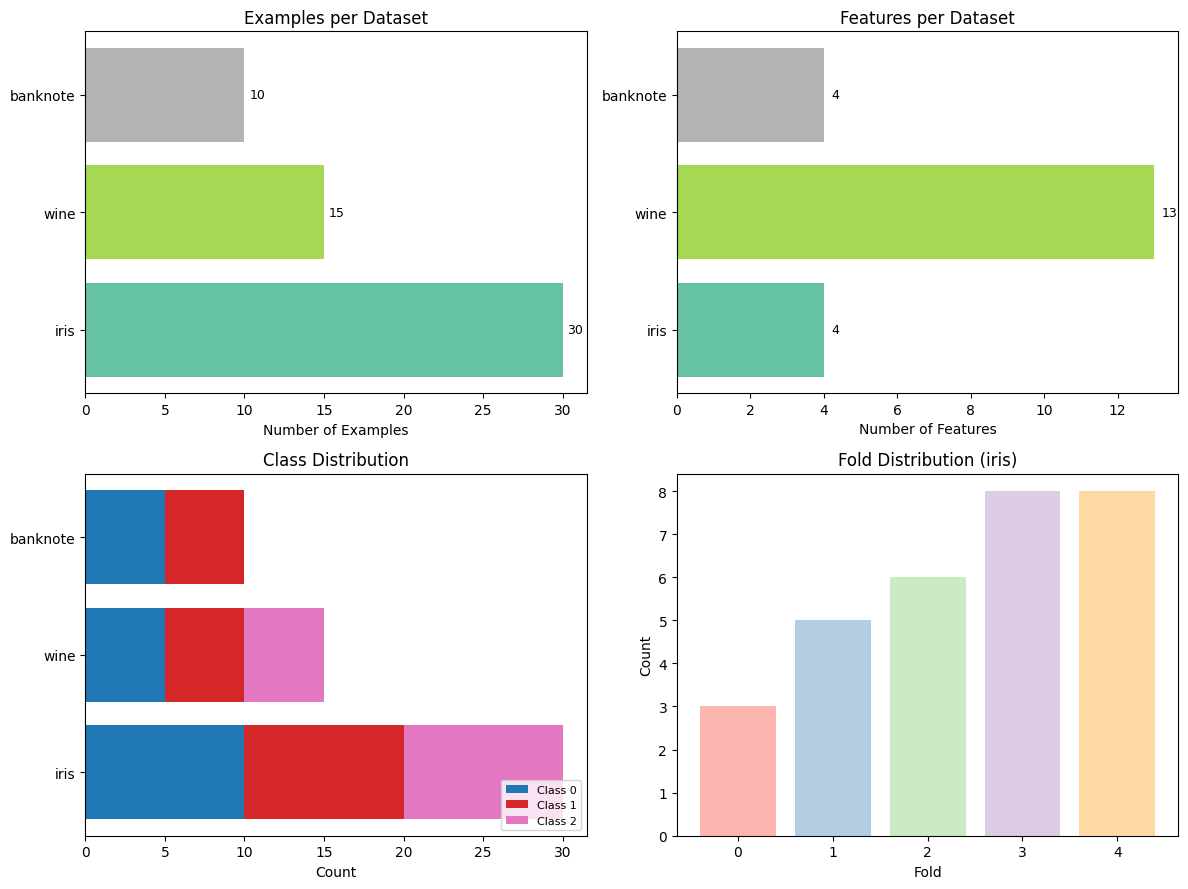

Saved visualization to benchmark_overview.png


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

# --- Plot 1: Examples per dataset ---
ax = axes[0, 0]
names = [ds["dataset"] for ds in processed_datasets]
n_examples = [ds["n_examples"] for ds in processed_datasets]
colors = plt.cm.Set2(np.linspace(0, 1, len(names)))
ax.barh(names, n_examples, color=colors)
ax.set_xlabel("Number of Examples")
ax.set_title("Examples per Dataset")
for i, v in enumerate(n_examples):
    ax.text(v + 0.3, i, str(v), va="center", fontsize=9)

# --- Plot 2: Feature counts per dataset ---
ax = axes[0, 1]
n_features = [ds["n_features"] for ds in processed_datasets]
ax.barh(names, n_features, color=colors)
ax.set_xlabel("Number of Features")
ax.set_title("Features per Dataset")
for i, v in enumerate(n_features):
    ax.text(v + 0.2, i, str(v), va="center", fontsize=9)

# --- Plot 3: Class distribution (stacked bar) ---
ax = axes[1, 0]
max_classes = max(ds["n_classes"] for ds in processed_datasets)
bottom = np.zeros(len(processed_datasets))
for c in range(max_classes):
    counts = []
    for ds in processed_datasets:
        df = ds["df"]
        counts.append((df["target"] == c).sum())
    ax.barh(names, counts, left=bottom, label=f"Class {c}",
            color=plt.cm.tab10(c / max_classes))
    bottom += np.array(counts)
ax.set_xlabel("Count")
ax.set_title("Class Distribution")
ax.legend(loc="lower right", fontsize=8)

# --- Plot 4: Fold distribution for first dataset ---
ax = axes[1, 1]
first_ds = processed_datasets[0]
fold_counts = first_ds["df"]["fold"].value_counts().sort_index()
ax.bar(fold_counts.index, fold_counts.values, color=plt.cm.Pastel1.colors[:len(fold_counts)])
ax.set_xlabel("Fold")
ax.set_ylabel("Count")
ax.set_title(f"Fold Distribution ({first_ds['dataset']})")
ax.set_xticks(range(N_FOLDS))

plt.tight_layout()
plt.savefig("benchmark_overview.png", dpi=100, bbox_inches="tight")
plt.show()
print("Saved visualization to benchmark_overview.png")